# Setup enviorment

In [1]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band8.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043     2044  \
41001 201546 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   
      201547 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   
      201548 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   
      201549 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   
      201550 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.937446  -1.0 -0.861740  
      201547  -1.0 -0.937446  -1.0 -0.854589  
      201548  -1.0 -0.937446  -1.0 -0.856973  
      201549  -1.0 -0.937446  -1.0 -0.856973  
      201550  -1.0 -0.937446  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2    3         4    5         6  \
41001 201820 -1.000000 -0.941595 -0.819990 -1.0 -1.000000 -1.0 -0.936327   
      201821 -0.961554 -1.000000 -0.997586 -1.0 -1.000000 -1.0 -0.991534   
      201822  1.548908 -0.951237 -0.936756 -1.0 -0.993773 -1.0 -0.732478   
      201823 -1.000000 -0.929855 -0.611671 -1.0 -1.000000 -1.0 -1.000000   
      201824 -1.000000 -1.000000 -0.982490 -1.0 -0.306486 -1.0 -0.432695   

                     7         8         9  ...  2039      2040      2041  \
41001 201820 -1.000000 -0.902987 -0.735931  ...  -1.0  0.796421 -1.000000   
      201821 -0.188850 -1.000000 -0.923532  ...  -1.0 -0.602157 -0.972147   
      201822  0.218282 -0.932164 -1.000000  ...  -1.0 -0.757050 -1.000000   
      201823 -1.000000 -0.918102 -0.808006  ...  -1.0 -0.949974 -1.000000   
      201824 -1.000000 -0.984359 -0.998801  ...  -1.0 -0.800901 -0.836477   

              2042      2043      2044      2045      2046      2047    Labels  
41001 201820  -1.0 -0.911150 -1.000000 -1.000000 -0.993271 -1.000000 -0.949940  
      201821  -1.0 -0.949700 -1.000000 -1.000000 -0.565648 -0.584606 -0.961859  
      201822  -1.0 -0.929634 -0.901203 -1.000000 -0.390393 -0.755579 -0.940405  
      201823  -1.0 -1.000000 -1.000000 -0.963915 -1.000000 -1.000000 -0.961859  
      201824  -1.0 -0.921778 -1.000000 -1.000000 -0.279108 -0.970131 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

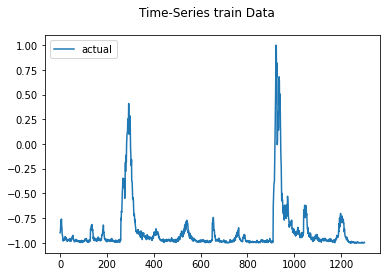

2023-03-07 14:48:58.961461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 14:48:58.961522: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 14:48:58.961553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-07 14:48:58.961813: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 14:48:59.311979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 40.336
Test RMSE: 55.352
Test sMAPE: 115.259
Test R Squared: -2.170
{'mae': 40.336125115734156, 'rmse': 55.352158572469286, 'smape': 115.25881822033475, 'r2': -2.170378580508879}


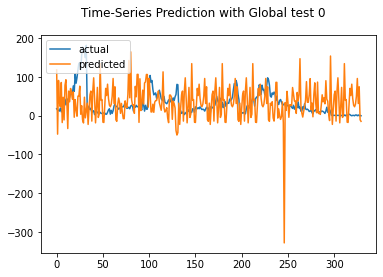

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 45.652
Test RMSE: 56.033
Test sMAPE: 101.114
Test R Squared: -2.249
{'mae': 45.65186257542986, 'rmse': 56.03254600797391, 'smape': 101.11427561553344, 'r2': -2.2487980399009153}


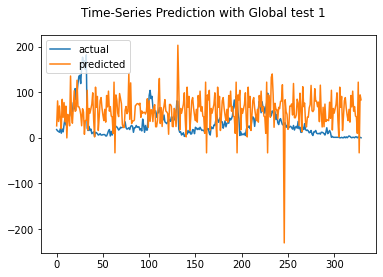

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 35.949
Test RMSE: 45.658
Test sMAPE: 98.544
Test R Squared: -1.157
{'mae': 35.94900033076604, 'rmse': 45.65843639862573, 'smape': 98.54384945240686, 'r2': -1.1571685060989978}


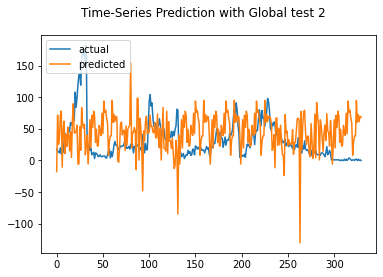

Test MAE: 72.518
Test RMSE: 100.511
Test sMAPE: 129.839
Test R Squared: -9.454
{'mae': 72.51839646046813, 'rmse': 100.51119885517824, 'smape': 129.83947126025822, 'r2': -9.453721068845581}


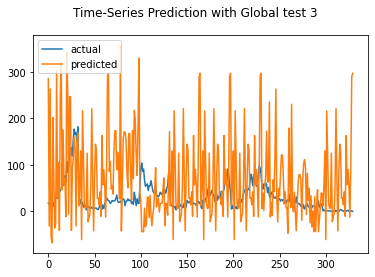

Test MAE: 36.657
Test RMSE: 45.197
Test sMAPE: 95.192
Test R Squared: -1.114
{'mae': 36.65685805371314, 'rmse': 45.197349028511574, 'smape': 95.19176343901394, 'r2': -1.1138196326839926}


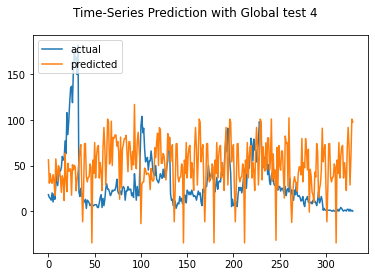

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 40.717
Test RMSE: 54.388
Test sMAPE: 105.143
Test R Squared: -2.061
{'mae': 40.71718128160997, 'rmse': 54.387838972909684, 'smape': 105.14341795089838, 'r2': -2.0608750953658106}


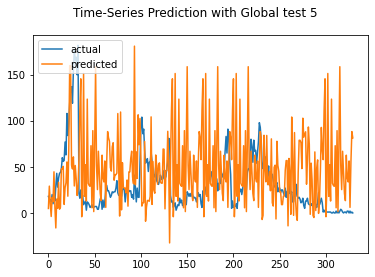

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 39.665
Test RMSE: 48.478
Test sMAPE: 102.720
Test R Squared: -1.432
{'mae': 39.66450958089395, 'rmse': 48.47831114527795, 'smape': 102.72041474873305, 'r2': -1.4318510172755738}


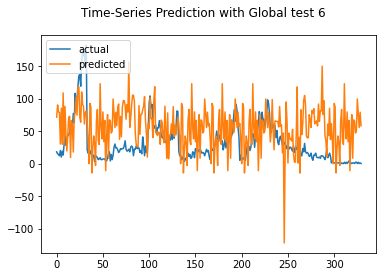

Test MAE: 43.221
Test RMSE: 53.668
Test sMAPE: 96.018
Test R Squared: -1.980
{'mae': 43.221483646739614, 'rmse': 53.6677004563539, 'smape': 96.01781834101783, 'r2': -1.9803548523113563}


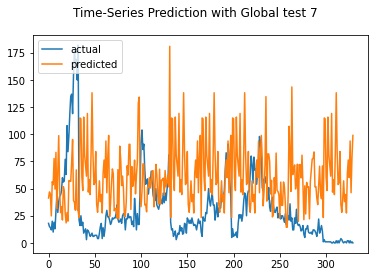

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 47.065
Test RMSE: 61.530
Test sMAPE: 120.656
Test R Squared: -2.918
{'mae': 47.064620485630904, 'rmse': 61.530120810238856, 'smape': 120.6560592086728, 'r2': -2.9175769636677793}


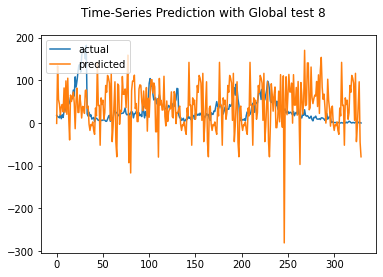

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 49.514
Test RMSE: 60.582
Test sMAPE: 120.043
Test R Squared: -2.798
{'mae': 49.51408011588183, 'rmse': 60.58157256741573, 'smape': 120.04301286497287, 'r2': -2.797721267347337}


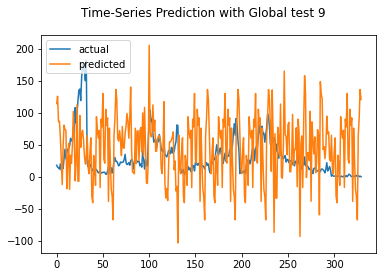

Test MAE: 28.457
Test RMSE: 36.264
Test sMAPE: 84.668
Test R Squared: -0.361
{'mae': 28.457055856603564, 'rmse': 36.26381240446771, 'smape': 84.6680404250311, 'r2': -0.36078314230685105}


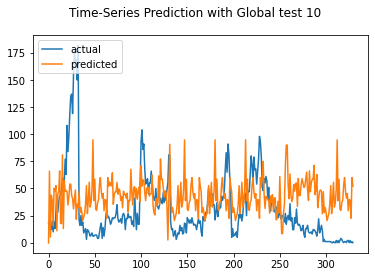

Test MAE: 61.460
Test RMSE: 73.576
Test sMAPE: 114.147
Test R Squared: -4.602
{'mae': 61.46028043988979, 'rmse': 73.5761193222264, 'smape': 114.14686130731403, 'r2': -4.601647256915274}


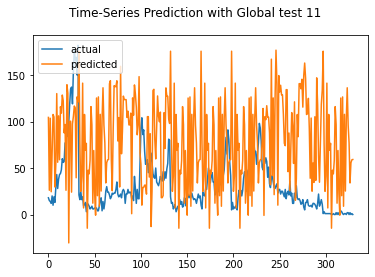

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 44.946
Test RMSE: 52.733
Test sMAPE: 103.534
Test R Squared: -1.877
{'mae': 44.94635184316924, 'rmse': 52.73299357359064, 'smape': 103.5338152166228, 'r2': -1.8774438274827978}


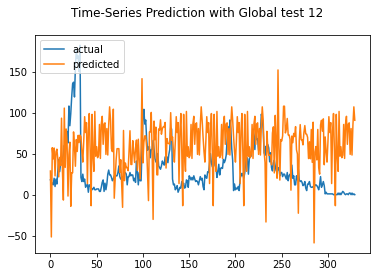

Test MAE: 65.380
Test RMSE: 74.177
Test sMAPE: 113.390
Test R Squared: -4.693
{'mae': 65.38048452030529, 'rmse': 74.17668539466287, 'smape': 113.3903406546871, 'r2': -4.693467519286139}


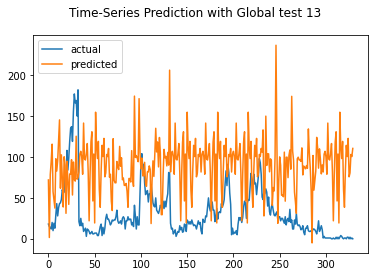

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 40.684
Test RMSE: 53.234
Test sMAPE: 109.535
Test R Squared: -1.932
{'mae': 40.684412412842114, 'rmse': 53.2335467797598, 'smape': 109.53490033146342, 'r2': -1.9323297546100116}


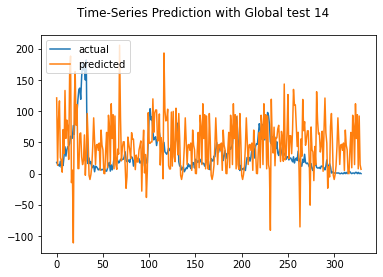

Test MAE: 49.219
Test RMSE: 59.561
Test sMAPE: 103.209
Test R Squared: -2.671
{'mae': 49.21896533821568, 'rmse': 59.56126733135997, 'smape': 103.2085556117017, 'r2': -2.6708772435300845}


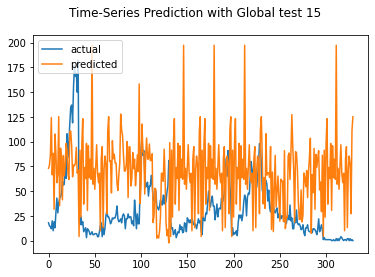

Test MAE: 86.679
Test RMSE: 108.580
Test sMAPE: 121.331
Test R Squared: -11.200
{'mae': 86.67851240851662, 'rmse': 108.58019611847853, 'smape': 121.33113819845283, 'r2': -11.19953409620702}


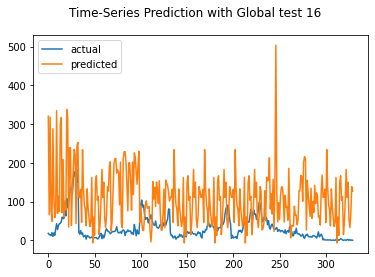

Test MAE: 46.181
Test RMSE: 57.536
Test sMAPE: 99.096
Test R Squared: -2.425
{'mae': 46.180610392310406, 'rmse': 57.5356032275147, 'smape': 99.09636042666283, 'r2': -2.4254319423024415}


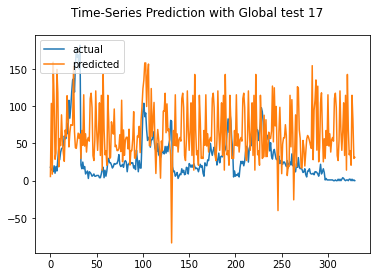

Test MAE: 52.594
Test RMSE: 63.894
Test sMAPE: 104.131
Test R Squared: -3.224
{'mae': 52.59413697647326, 'rmse': 63.89358494547224, 'smape': 104.13122018944202, 'r2': -3.224317128298688}


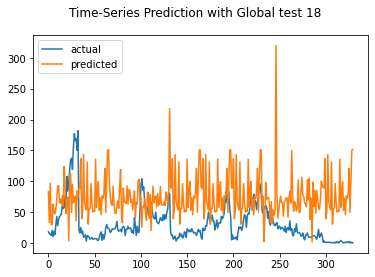

Test MAE: 67.114
Test RMSE: 82.521
Test sMAPE: 117.876
Test R Squared: -6.046
{'mae': 67.11358214815458, 'rmse': 82.52084846883436, 'smape': 117.87593921736374, 'r2': -6.046433716752273}


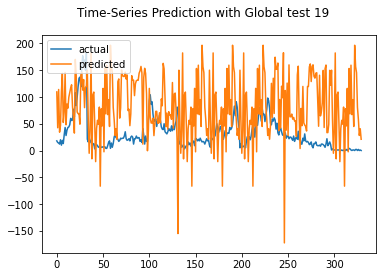

Test MAE: 41.213
Test RMSE: 53.207
Test sMAPE: 94.892
Test R Squared: -1.929
{'mae': 41.21301382418835, 'rmse': 53.206756845456546, 'smape': 94.89243200553557, 'r2': -1.9293790906308117}


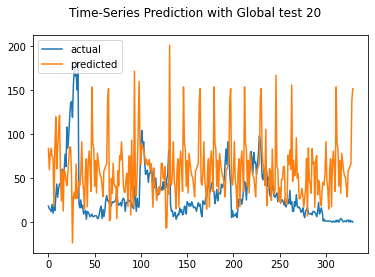

Test MAE: 57.771
Test RMSE: 85.670
Test sMAPE: 109.016
Test R Squared: -6.595
{'mae': 57.77112753978281, 'rmse': 85.67023282135239, 'smape': 109.01649592297494, 'r2': -6.594547381888397}


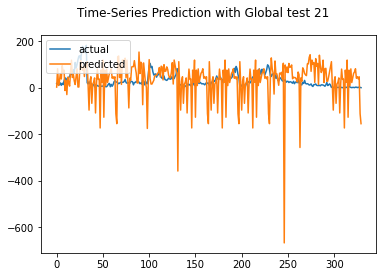

Test MAE: 37.218
Test RMSE: 47.274
Test sMAPE: 100.256
Test R Squared: -1.313
{'mae': 37.217765071536554, 'rmse': 47.27398506580579, 'smape': 100.25634306867877, 'r2': -1.3125249602512774}


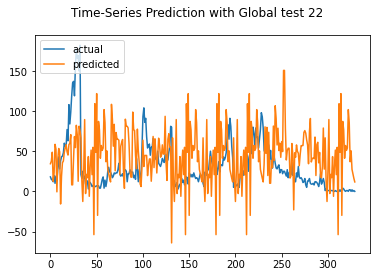

Test MAE: 56.114
Test RMSE: 69.708
Test sMAPE: 135.135
Test R Squared: -4.028
{'mae': 56.11372462836179, 'rmse': 69.70824166974863, 'smape': 135.13490353977352, 'r2': -4.0281735365207485}


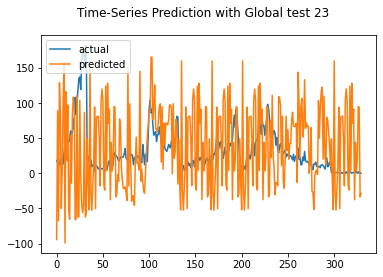

Test MAE: 54.249
Test RMSE: 71.905
Test sMAPE: 105.026
Test R Squared: -4.350
{'mae': 54.24921984067469, 'rmse': 71.90483278327595, 'smape': 105.02572180794839, 'r2': -4.350053968488699}


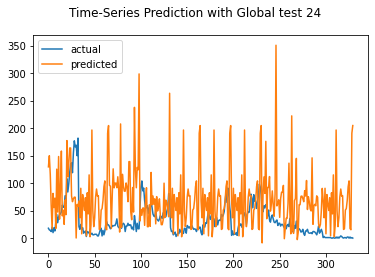

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 47.012
Test RMSE: 60.112
Test sMAPE: 127.341
Test R Squared: -2.739
{'mae': 47.011547903400476, 'rmse': 60.1122100172723, 'smape': 127.34113018118305, 'r2': -2.7391026817827866}


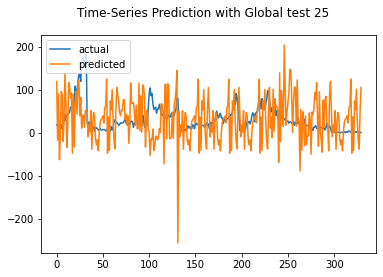

Test MAE: 73.581
Test RMSE: 110.354
Test sMAPE: 119.920
Test R Squared: -11.601
{'mae': 73.58119121717684, 'rmse': 110.35363345051964, 'smape': 119.91967116971743, 'r2': -11.601297821061728}


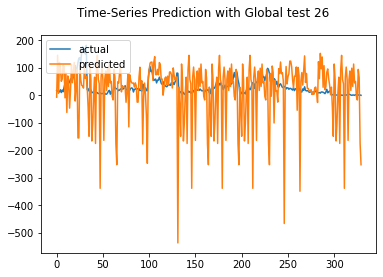

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 33.322
Test RMSE: 42.542
Test sMAPE: 99.431
Test R Squared: -0.873
{'mae': 33.32182548371228, 'rmse': 42.54236660315879, 'smape': 99.4314518758818, 'r2': -0.8727736628019003}


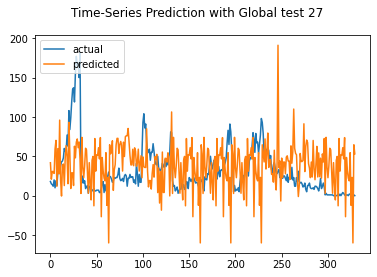

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 40.983
Test RMSE: 54.663
Test sMAPE: 105.653
Test R Squared: -2.092
{'mae': 40.98323820973888, 'rmse': 54.66346354179671, 'smape': 105.65255876896197, 'r2': -2.091977272207467}


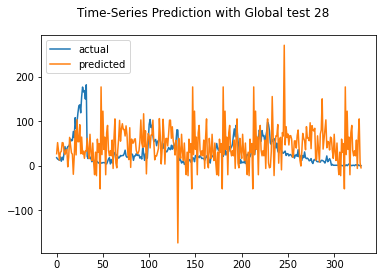

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 52.573
Test RMSE: 66.412
Test sMAPE: 118.926
Test R Squared: -3.564
{'mae': 52.57251299439054, 'rmse': 66.41238568425311, 'smape': 118.92635871471889, 'r2': -3.5639425019654336}


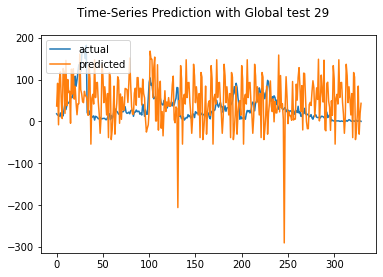

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 40.602
Test RMSE: 51.086
Test sMAPE: 107.244
Test R Squared: -1.701
{'mae': 40.60159165281238, 'rmse': 51.08606572203231, 'smape': 107.2435408840817, 'r2': -1.700517010184508}


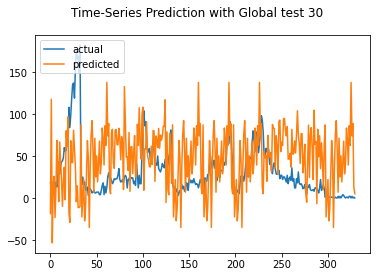

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 44.235
Test RMSE: 55.327
Test sMAPE: 106.635
Test R Squared: -2.168
{'mae': 44.23469999793804, 'rmse': 55.32704454026533, 'smape': 106.63506785793608, 'r2': -2.1675023448116275}


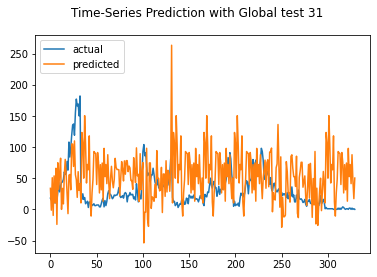

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 39.593
Test RMSE: 50.794
Test sMAPE: 105.926
Test R Squared: -1.670
{'mae': 39.59273231444937, 'rmse': 50.79352965769137, 'smape': 105.92640737405851, 'r2': -1.6696774179287557}


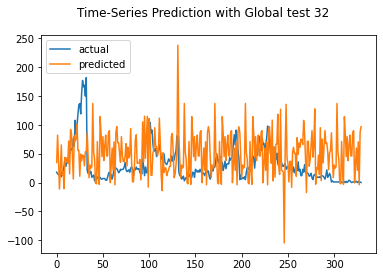

Test MAE: 50.055
Test RMSE: 69.143
Test sMAPE: 123.090
Test R Squared: -3.947
{'mae': 50.054569618087825, 'rmse': 69.1434050202557, 'smape': 123.09038385484203, 'r2': -3.947018420224226}


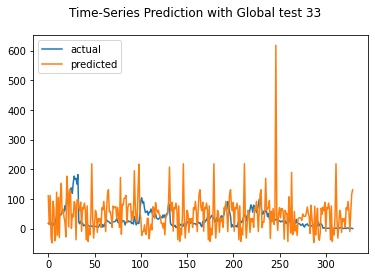

Test MAE: 67.974
Test RMSE: 76.325
Test sMAPE: 114.315
Test R Squared: -5.028
{'mae': 67.97406895666411, 'rmse': 76.32540618202303, 'smape': 114.3152247369849, 'r2': -5.028097248908313}


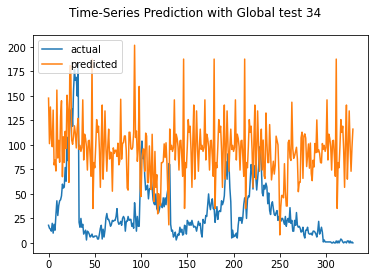

Test MAE: 74.724
Test RMSE: 91.920
Test sMAPE: 114.786
Test R Squared: -7.743
{'mae': 74.72437660621874, 'rmse': 91.92047189152983, 'smape': 114.78615579625266, 'r2': -7.743121065991147}


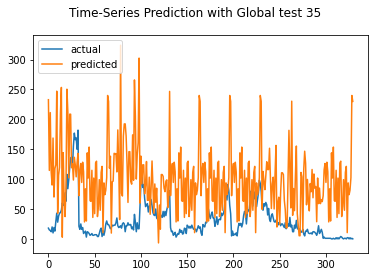

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 37.737
Test RMSE: 46.911
Test sMAPE: 96.473
Test R Squared: -1.277
{'mae': 37.73669242533771, 'rmse': 46.91063326947791, 'smape': 96.47280134613703, 'r2': -1.2771130548424687}


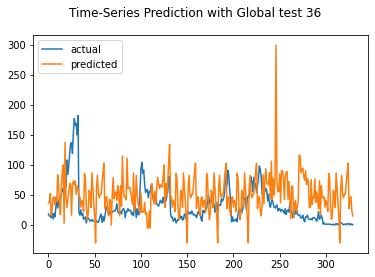

Test MAE: 56.108
Test RMSE: 67.697
Test sMAPE: 122.614
Test R Squared: -3.742
{'mae': 56.10794927947449, 'rmse': 67.69673999401071, 'smape': 122.61448806462828, 'r2': -3.7421742966421627}


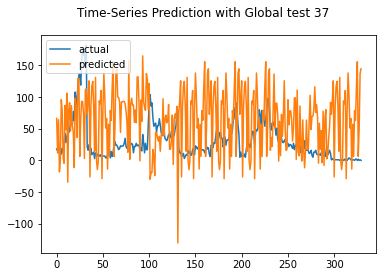

Test MAE: 28.225
Test RMSE: 38.483
Test sMAPE: 101.718
Test R Squared: -0.532
{'mae': 28.224791554519623, 'rmse': 38.48302659778903, 'smape': 101.71822161898031, 'r2': -0.532429287419008}


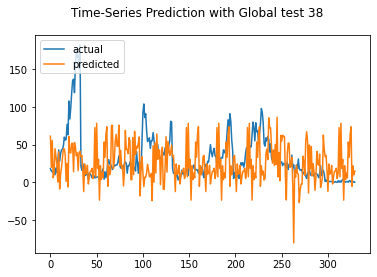

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 38.728
Test RMSE: 48.739
Test sMAPE: 112.363
Test R Squared: -1.458
{'mae': 38.72836304758534, 'rmse': 48.73880469649452, 'smape': 112.3633912795815, 'r2': -1.4580558692412597}


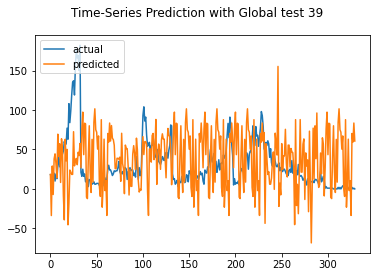

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 35.883
Test RMSE: 46.746
Test sMAPE: 101.170
Test R Squared: -1.261
{'mae': 35.882894998246975, 'rmse': 46.74597814891524, 'smape': 101.16962137360731, 'r2': -1.2611558917628476}


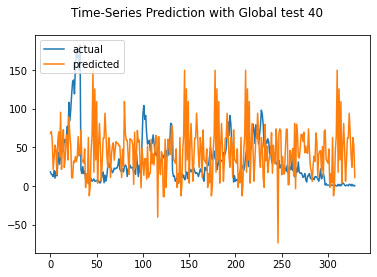

Test MAE: 72.656
Test RMSE: 90.748
Test sMAPE: 113.565
Test R Squared: -7.521
{'mae': 72.6558456767689, 'rmse': 90.74793836732687, 'smape': 113.56522892093957, 'r2': -7.5214899570720934}


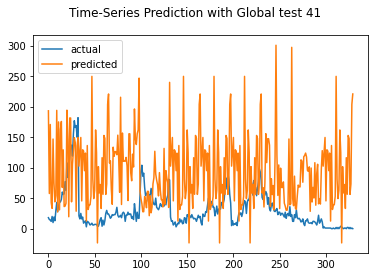

Test MAE: 52.037
Test RMSE: 68.534
Test sMAPE: 112.431
Test R Squared: -3.860
{'mae': 52.03678044893525, 'rmse': 68.5344806224995, 'smape': 112.43147675746152, 'r2': -3.8602684039927473}


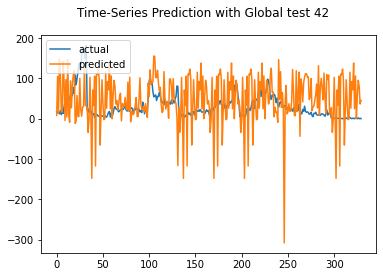

Test MAE: 51.281
Test RMSE: 58.421
Test sMAPE: 106.783
Test R Squared: -2.532
{'mae': 51.28121964606372, 'rmse': 58.42099314955555, 'smape': 106.78294281160392, 'r2': -2.531668021784043}


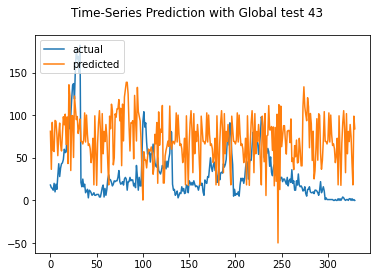

Test MAE: 68.011
Test RMSE: 84.432
Test sMAPE: 123.944
Test R Squared: -6.377
{'mae': 68.01062216036247, 'rmse': 84.43153112606622, 'smape': 123.94436690301019, 'r2': -6.376516731205413}


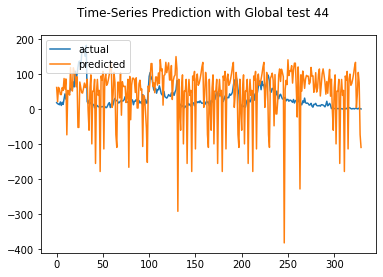

Test MAE: 36.109
Test RMSE: 45.925
Test sMAPE: 103.806
Test R Squared: -1.182
{'mae': 36.10886493975466, 'rmse': 45.92472986394991, 'smape': 103.8063014908408, 'r2': -1.182404369330345}


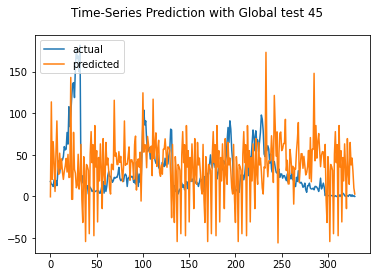

Test MAE: 43.791
Test RMSE: 49.953
Test sMAPE: 100.904
Test R Squared: -1.582
{'mae': 43.79055658398253, 'rmse': 49.952723116802666, 'smape': 100.90404577075535, 'r2': -1.5820243775466287}


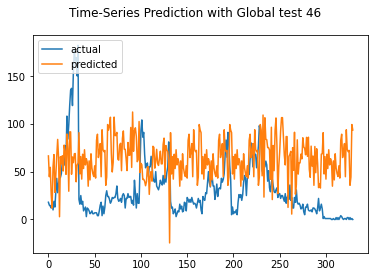

Test MAE: 60.252
Test RMSE: 77.092
Test sMAPE: 120.718
Test R Squared: -5.150
{'mae': 60.25222123789065, 'rmse': 77.09207722782868, 'smape': 120.71780662395894, 'r2': -5.149807152415434}


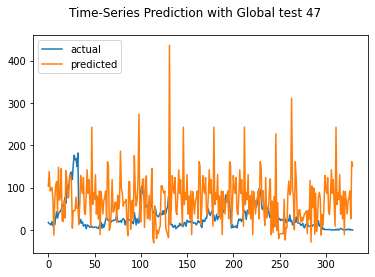

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 38.830
Test RMSE: 49.653
Test sMAPE: 116.071
Test R Squared: -1.551
{'mae': 38.83009071747462, 'rmse': 49.65264592634547, 'smape': 116.07064739977945, 'r2': -1.5510959574607903}


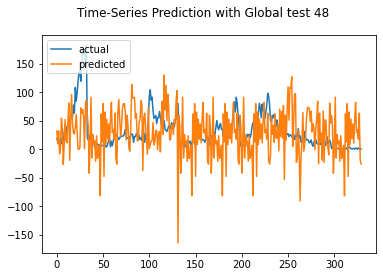

Test MAE: 51.713
Test RMSE: 62.961
Test sMAPE: 102.683
Test R Squared: -3.102
{'mae': 51.71319025068572, 'rmse': 62.961319400664365, 'smape': 102.68289812200342, 'r2': -3.101943201126794}


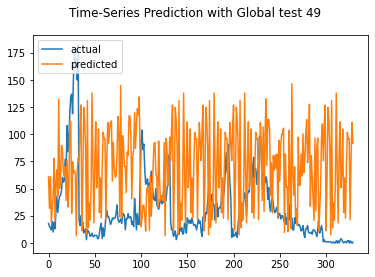

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 39.358
Test RMSE: 48.839
Test sMAPE: 110.837
Test R Squared: -1.468
{'mae': 39.35772157203068, 'rmse': 48.83937235506071, 'smape': 110.83724816394437, 'r2': -1.4682102405743618}


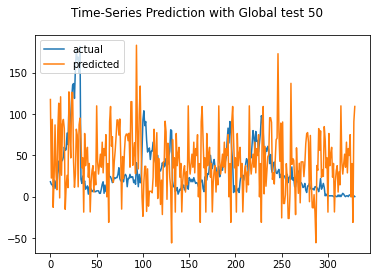

Test MAE: 42.218
Test RMSE: 53.542
Test sMAPE: 106.139
Test R Squared: -1.966
{'mae': 42.21848703839562, 'rmse': 53.54219697160453, 'smape': 106.13866000805862, 'r2': -1.9664318573220463}


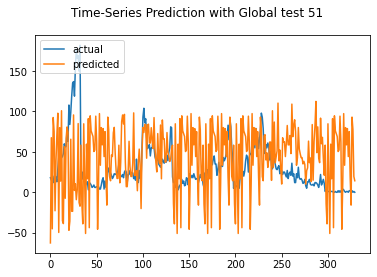

Test MAE: 38.999
Test RMSE: 48.769
Test sMAPE: 107.013
Test R Squared: -1.461
{'mae': 38.99918271411549, 'rmse': 48.76945626568508, 'smape': 107.01338389652173, 'r2': -1.4611485573572636}


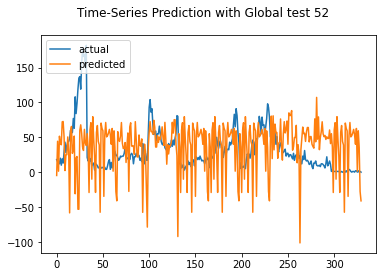

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 48.555
Test RMSE: 61.936
Test sMAPE: 127.148
Test R Squared: -2.969
{'mae': 48.55503716378501, 'rmse': 61.93617334569415, 'smape': 127.148403666524, 'r2': -2.969453699442421}


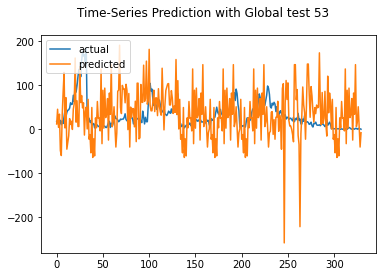

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 52.000
Test RMSE: 63.273
Test sMAPE: 114.169
Test R Squared: -3.143
{'mae': 52.00014198946231, 'rmse': 63.273122211695565, 'smape': 114.16893842110824, 'r2': -3.1426718395059288}


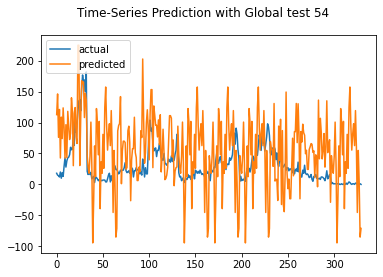

Test MAE: 44.645
Test RMSE: 55.005
Test sMAPE: 122.280
Test R Squared: -2.131
{'mae': 44.64493731007431, 'rmse': 55.00473463164956, 'smape': 122.2801958090959, 'r2': -2.130705017131193}


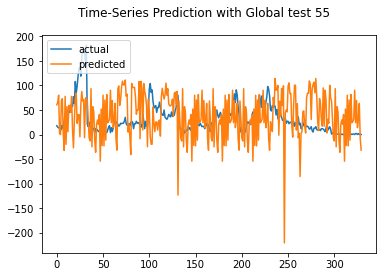

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 49.059
Test RMSE: 58.361
Test sMAPE: 106.971
Test R Squared: -2.524
{'mae': 49.059420616698986, 'rmse': 58.36080350411849, 'smape': 106.97069245262206, 'r2': -2.524394597216666}


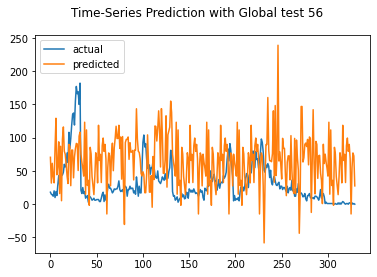

Test MAE: 34.430
Test RMSE: 43.781
Test sMAPE: 103.865
Test R Squared: -0.983
{'mae': 34.429612291220465, 'rmse': 43.78084951014956, 'smape': 103.86531438639784, 'r2': -0.9834002796216748}


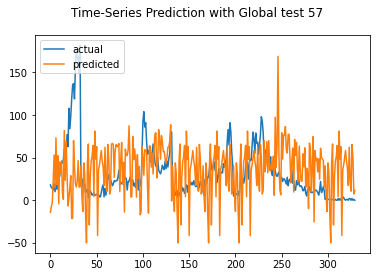

Test MAE: 53.096
Test RMSE: 63.525
Test sMAPE: 119.615
Test R Squared: -3.176
{'mae': 53.09602278940606, 'rmse': 63.5254093296929, 'smape': 119.61476038781358, 'r2': -3.1757736159484313}


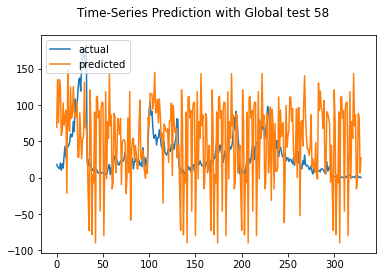

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 38.718
Test RMSE: 47.432
Test sMAPE: 104.305
Test R Squared: -1.328
{'mae': 38.71762510538101, 'rmse': 47.431578989412714, 'smape': 104.30514905388797, 'r2': -1.327968859684808}


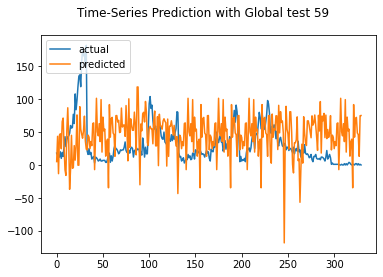

Test MAE: 41.247
Test RMSE: 56.756
Test sMAPE: 101.620
Test R Squared: -2.333
{'mae': 41.246655529556854, 'rmse': 56.75605587733244, 'smape': 101.62006405734117, 'r2': -2.3332387106756487}


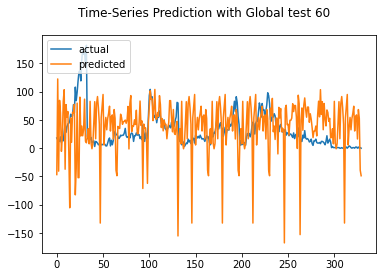

Test MAE: 47.975
Test RMSE: 69.817
Test sMAPE: 127.284
Test R Squared: -4.044
{'mae': 47.975225877942464, 'rmse': 69.81711239095468, 'smape': 127.28357363915448, 'r2': -4.043891860456078}


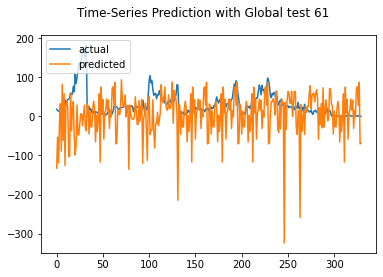

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 46.354
Test RMSE: 61.235
Test sMAPE: 126.104
Test R Squared: -2.880
{'mae': 46.35376353652188, 'rmse': 61.235371136350466, 'smape': 126.10406406520389, 'r2': -2.8801338769786486}


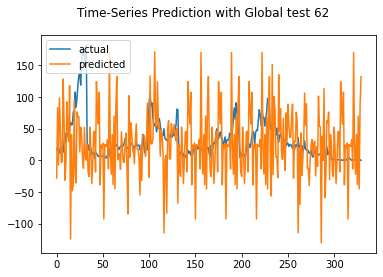

Test MAE: 37.367
Test RMSE: 45.456
Test sMAPE: 93.101
Test R Squared: -1.138
{'mae': 37.36660208575653, 'rmse': 45.45639147347051, 'smape': 93.1014793573345, 'r2': -1.1381192067171653}


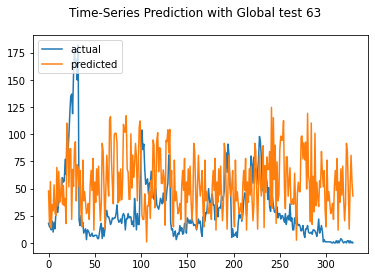

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 30.087
Test RMSE: 38.785
Test sMAPE: 99.647
Test R Squared: -0.557
{'mae': 30.086901611270328, 'rmse': 38.78480224852367, 'smape': 99.64746700647626, 'r2': -0.5565574864080747}


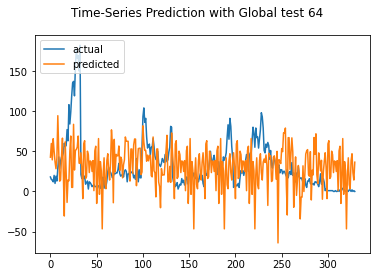

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 47.428
Test RMSE: 56.001
Test sMAPE: 111.763
Test R Squared: -2.245
{'mae': 47.42759006565267, 'rmse': 56.000594541770965, 'smape': 111.76261556373633, 'r2': -2.24509396888854}


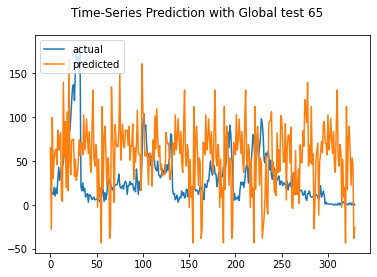

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 33.411
Test RMSE: 42.861
Test sMAPE: 91.972
Test R Squared: -0.901
{'mae': 33.41090054512024, 'rmse': 42.86115393983552, 'smape': 91.97150604099437, 'r2': -0.9009457378607453}


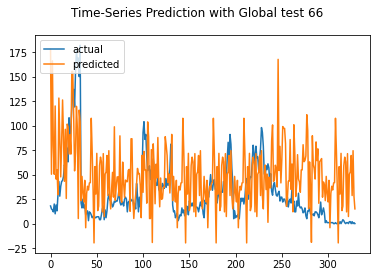

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 37.977
Test RMSE: 49.503
Test sMAPE: 102.973
Test R Squared: -1.536
{'mae': 37.9774018990271, 'rmse': 49.50260455408925, 'smape': 102.97331539738649, 'r2': -1.5357013455482118}


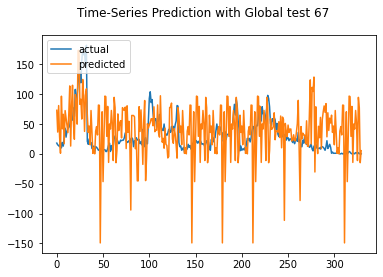

Test MAE: 52.658
Test RMSE: 64.455
Test sMAPE: 103.304
Test R Squared: -3.299
{'mae': 52.65785567543723, 'rmse': 64.45463505620526, 'smape': 103.30442137605081, 'r2': -3.2988303779456807}


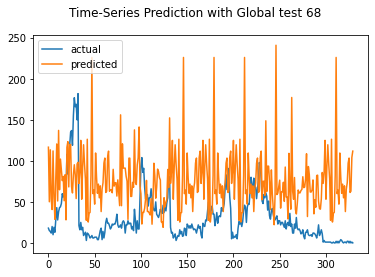

Test MAE: 81.378
Test RMSE: 102.795
Test sMAPE: 116.383
Test R Squared: -9.934
{'mae': 81.3776101025668, 'rmse': 102.79549879453909, 'smape': 116.38310551291215, 'r2': -9.934280180351852}


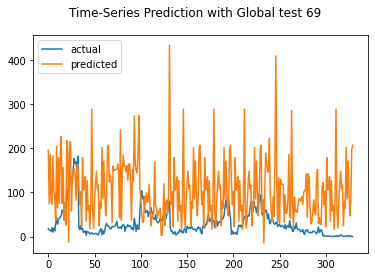

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 46.012
Test RMSE: 60.623
Test sMAPE: 127.907
Test R Squared: -2.803
{'mae': 46.01207441669522, 'rmse': 60.62318390595098, 'smape': 127.9065457797597, 'r2': -2.802940099762227}


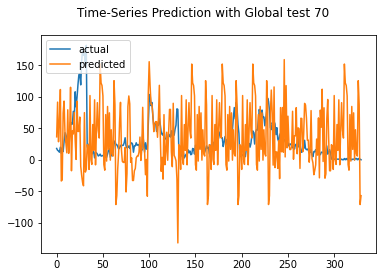

Test MAE: 47.263
Test RMSE: 54.753
Test sMAPE: 109.297
Test R Squared: -2.102
{'mae': 47.26264791994384, 'rmse': 54.752794556823915, 'smape': 109.29655926128255, 'r2': -2.1020913462514303}


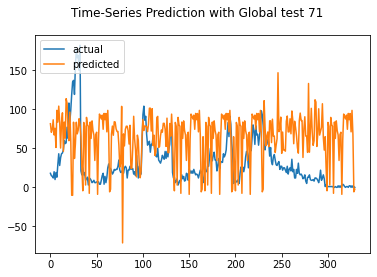

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 43.697
Test RMSE: 55.079
Test sMAPE: 120.637
Test R Squared: -2.139
{'mae': 43.69682672186331, 'rmse': 55.07896112402909, 'smape': 120.63690276626069, 'r2': -2.139160218227621}


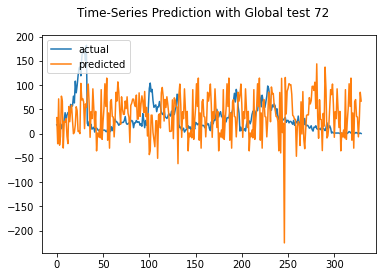

Test MAE: 68.049
Test RMSE: 88.382
Test sMAPE: 125.329
Test R Squared: -7.083
{'mae': 68.04914940180201, 'rmse': 88.38249602293175, 'smape': 125.32943561413272, 'r2': -7.083036248631341}


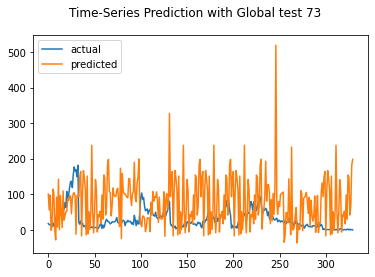

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 41.923
Test RMSE: 53.642
Test sMAPE: 111.922
Test R Squared: -1.977
{'mae': 41.922990495327745, 'rmse': 53.64179299945193, 'smape': 111.92212268412572, 'r2': -1.977478083704006}


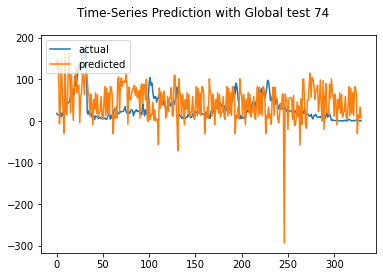

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 58.184
Test RMSE: 72.971
Test sMAPE: 113.328
Test R Squared: -4.510
{'mae': 58.184118380962, 'rmse': 72.97097824323072, 'smape': 113.32777697234788, 'r2': -4.50988251269713}


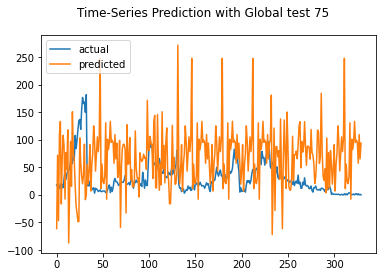

Test MAE: 59.679
Test RMSE: 93.970
Test sMAPE: 100.993
Test R Squared: -8.137
{'mae': 59.67863108317057, 'rmse': 93.96976432421489, 'smape': 100.99301071818296, 'r2': -8.13730826553666}


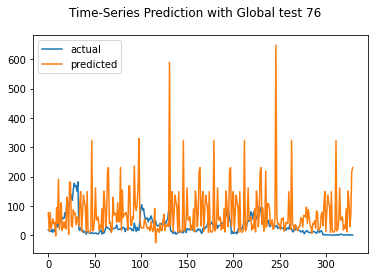

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 40.379
Test RMSE: 49.442
Test sMAPE: 99.532
Test R Squared: -1.529
{'mae': 40.379362272493765, 'rmse': 49.44197339795626, 'smape': 99.53241567037293, 'r2': -1.529493657969161}


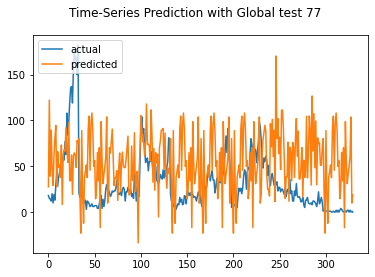

Test MAE: 40.011
Test RMSE: 56.470
Test sMAPE: 113.949
Test R Squared: -2.300
{'mae': 40.01072235667344, 'rmse': 56.47031153400375, 'smape': 113.94857130207426, 'r2': -2.299760116133542}


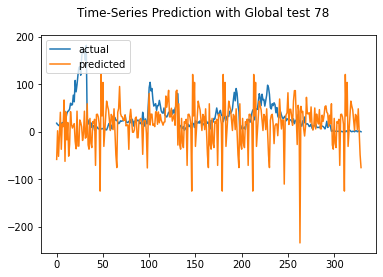

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 36.973
Test RMSE: 47.798
Test sMAPE: 103.087
Test R Squared: -1.364
{'mae': 36.97271230943275, 'rmse': 47.797608403658344, 'smape': 103.08699185640228, 'r2': -1.3640373584797287}


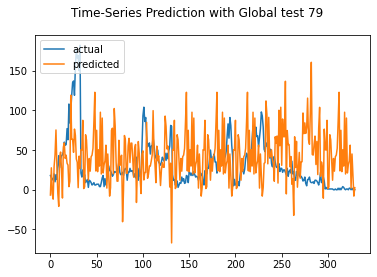

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 33.062
Test RMSE: 43.445
Test sMAPE: 105.144
Test R Squared: -0.953
{'mae': 33.06190888683001, 'rmse': 43.44496044965367, 'smape': 105.14413455819758, 'r2': -0.9530835135844504}


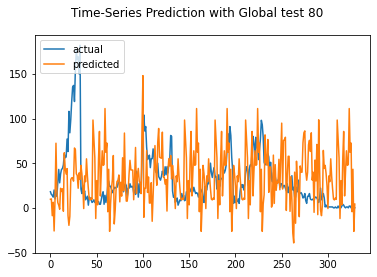

Test MAE: 49.715
Test RMSE: 63.254
Test sMAPE: 119.436
Test R Squared: -3.140
{'mae': 49.714938636530526, 'rmse': 63.25449052495587, 'smape': 119.43574214890855, 'r2': -3.1402324593341753}


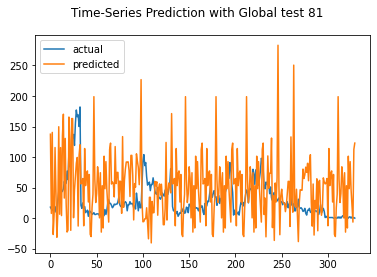

Test MAE: 70.456
Test RMSE: 79.419
Test sMAPE: 116.061
Test R Squared: -5.527
{'mae': 70.45633089470141, 'rmse': 79.41856216506532, 'smape': 116.06138620496323, 'r2': -5.526585652044979}


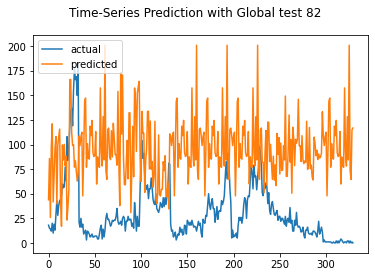

Test MAE: 51.798
Test RMSE: 62.677
Test sMAPE: 105.156
Test R Squared: -3.065
{'mae': 51.79831255132502, 'rmse': 62.676609768192826, 'smape': 105.15571169744481, 'r2': -3.0649292939174257}


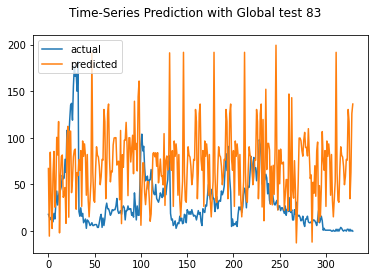

Test MAE: 40.175
Test RMSE: 47.146
Test sMAPE: 103.481
Test R Squared: -1.300
{'mae': 40.17476272113395, 'rmse': 47.145782267281504, 'smape': 103.48067835530573, 'r2': -1.2999992479294527}


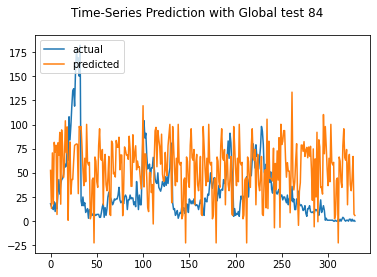

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 36.966
Test RMSE: 45.876
Test sMAPE: 95.360
Test R Squared: -1.178
{'mae': 36.96580650372939, 'rmse': 45.87592903604196, 'smape': 95.36014775613964, 'r2': -1.1777686728832544}


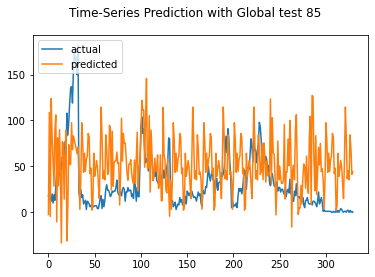

Test MAE: 46.716
Test RMSE: 61.969
Test sMAPE: 146.927
Test R Squared: -2.974
{'mae': 46.71625539561113, 'rmse': 61.968915653432255, 'smape': 146.92659598372344, 'r2': -2.973651680085064}


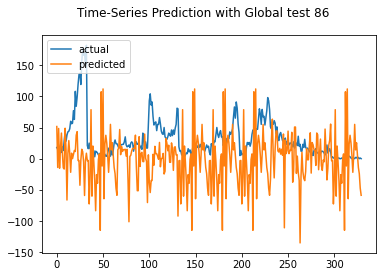

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 43.205
Test RMSE: 55.198
Test sMAPE: 122.727
Test R Squared: -2.153
{'mae': 43.20535721182823, 'rmse': 55.198047459620305, 'smape': 122.7267802432504, 'r2': -2.1527492623950497}


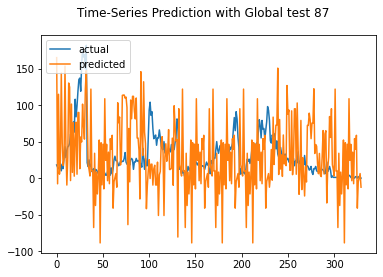

Test MAE: 37.262
Test RMSE: 43.991
Test sMAPE: 97.581
Test R Squared: -1.002
{'mae': 37.26162764863535, 'rmse': 43.991066330167705, 'smape': 97.58078829094111, 'r2': -1.0024928782099725}


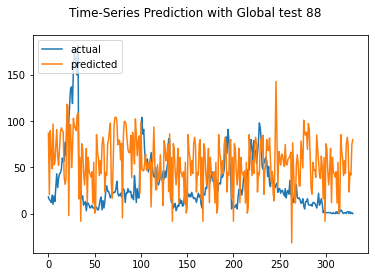

Test MAE: 30.311
Test RMSE: 39.942
Test sMAPE: 92.355
Test R Squared: -0.651
{'mae': 30.311222379315982, 'rmse': 39.941847694445215, 'smape': 92.35476572725992, 'r2': -0.6508146117016023}


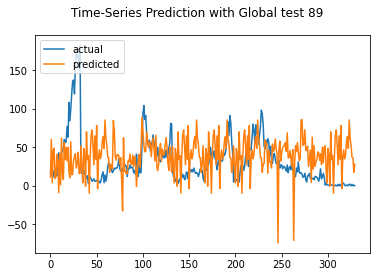

Test MAE: 35.930
Test RMSE: 45.513
Test sMAPE: 105.453
Test R Squared: -1.143
{'mae': 35.92999480746009, 'rmse': 45.51295958421143, 'smape': 105.45308100815944, 'r2': -1.1434440738142087}


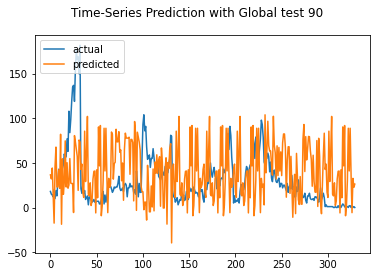

Test MAE: 75.279
Test RMSE: 87.083
Test sMAPE: 117.296
Test R Squared: -6.847
{'mae': 75.27874226425634, 'rmse': 87.0834196976324, 'smape': 117.29579185477792, 'r2': -6.8471680245982816}


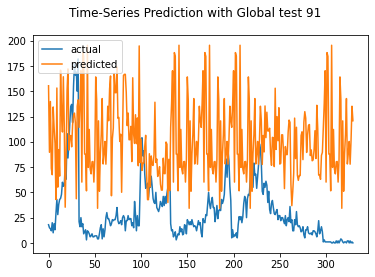

Test MAE: 48.985
Test RMSE: 62.543
Test sMAPE: 107.379
Test R Squared: -3.048
{'mae': 48.98522124037598, 'rmse': 62.542606771783156, 'smape': 107.37885320536321, 'r2': -3.0475661848421307}


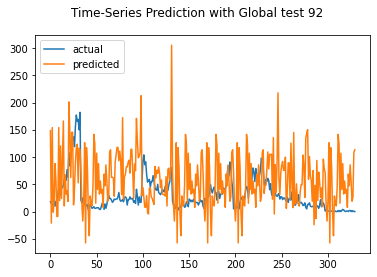

Test MAE: 53.890
Test RMSE: 68.884
Test sMAPE: 114.698
Test R Squared: -3.910
{'mae': 53.890450939987645, 'rmse': 68.88437367609711, 'smape': 114.69799605325699, 'r2': -3.9100219049328278}


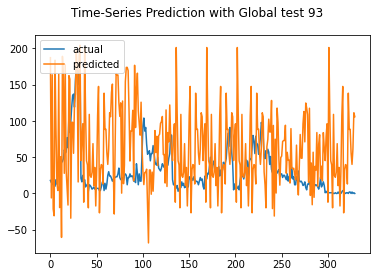

Test MAE: 83.677
Test RMSE: 109.723
Test sMAPE: 144.960
Test R Squared: -11.458
{'mae': 83.6772733710029, 'rmse': 109.72312170720733, 'smape': 144.9598711858289, 'r2': -11.457712727490279}


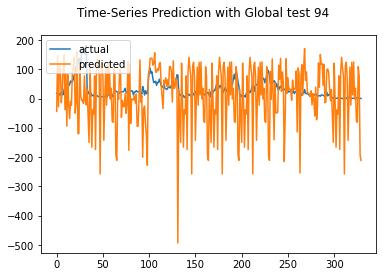

Test MAE: 44.990
Test RMSE: 54.836
Test sMAPE: 118.073
Test R Squared: -2.111
{'mae': 44.989998401385364, 'rmse': 54.835688868584775, 'smape': 118.0725209863788, 'r2': -2.1114914283927204}


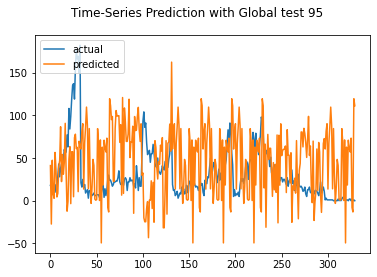

Test MAE: 67.926
Test RMSE: 77.026
Test sMAPE: 118.575
Test R Squared: -5.139
{'mae': 67.92638150056203, 'rmse': 77.02576236777834, 'smape': 118.5751840583177, 'r2': -5.13923153401982}


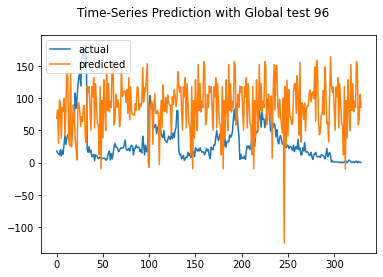

Test MAE: 78.529
Test RMSE: 94.475
Test sMAPE: 151.899
Test R Squared: -8.236
{'mae': 78.52895571571408, 'rmse': 94.47520261962067, 'smape': 151.8985124054807, 'r2': -8.235866902389905}


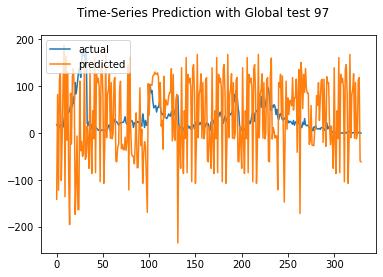

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 38.294
Test RMSE: 47.671
Test sMAPE: 109.113
Test R Squared: -1.352
{'mae': 38.29442175382918, 'rmse': 47.67146643641312, 'smape': 109.11332710464437, 'r2': -1.3515760308251163}


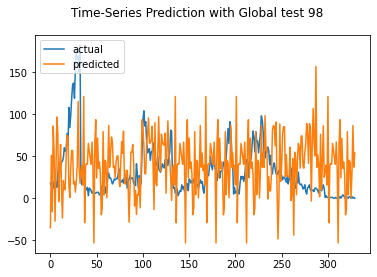

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 45.362
Test RMSE: 55.511
Test sMAPE: 108.096
Test R Squared: -2.189
{'mae': 45.36150677872426, 'rmse': 55.51065937795496, 'smape': 108.09590105278211, 'r2': -2.188561323022414}


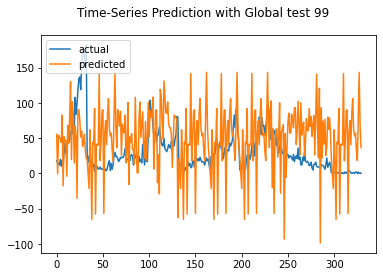

rmse : average=61.476, std=16.768
mae : average=48.682, std=13.063
smape : average=111.005, std=11.809
r2 : average=-3.202, std=2.490


([61.476487974817125, 16.768102362690406],
 [48.68243199290289, 13.062976600957446],
 [111.00526619492034, 11.809351538601325],
 [-3.2016947023862907, 2.490203992494883])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')